In [1]:
import pandas as pd
import json
import numpy as np

In [2]:
file = 'attention_matrices/metadata.json'

with open(file, 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.columns


FileNotFoundError: [Errno 2] No such file or directory: 'attention_matrices/metadata.json'

In [13]:
# df['num_nodes'].value_counts()
df['num_edges'].value_counts()

num_edges
21    33
20    31
19    31
17    27
22    25
18    23
23    22
16    22
25    17
24    12
15    10
27     9
26     7
14     7
28     6
29     5
30     4
13     3
12     2
10     2
9      2
Name: count, dtype: int64

Metadata JSON was a list; extracted the first dictionary element.
Successfully processed metadata from: /Users/log/Github/Spring2025Classes/social_networks/final_project/attention_matrices/demo1/metadata.json
Constructed full path to attention matrix: attention_matrices/demo1/combined/avg_matrix_0.npy
Successfully loaded attention matrix from: attention_matrices/demo1/combined/avg_matrix_0.npy
Final attention matrix shape for plotting: (21, 21)


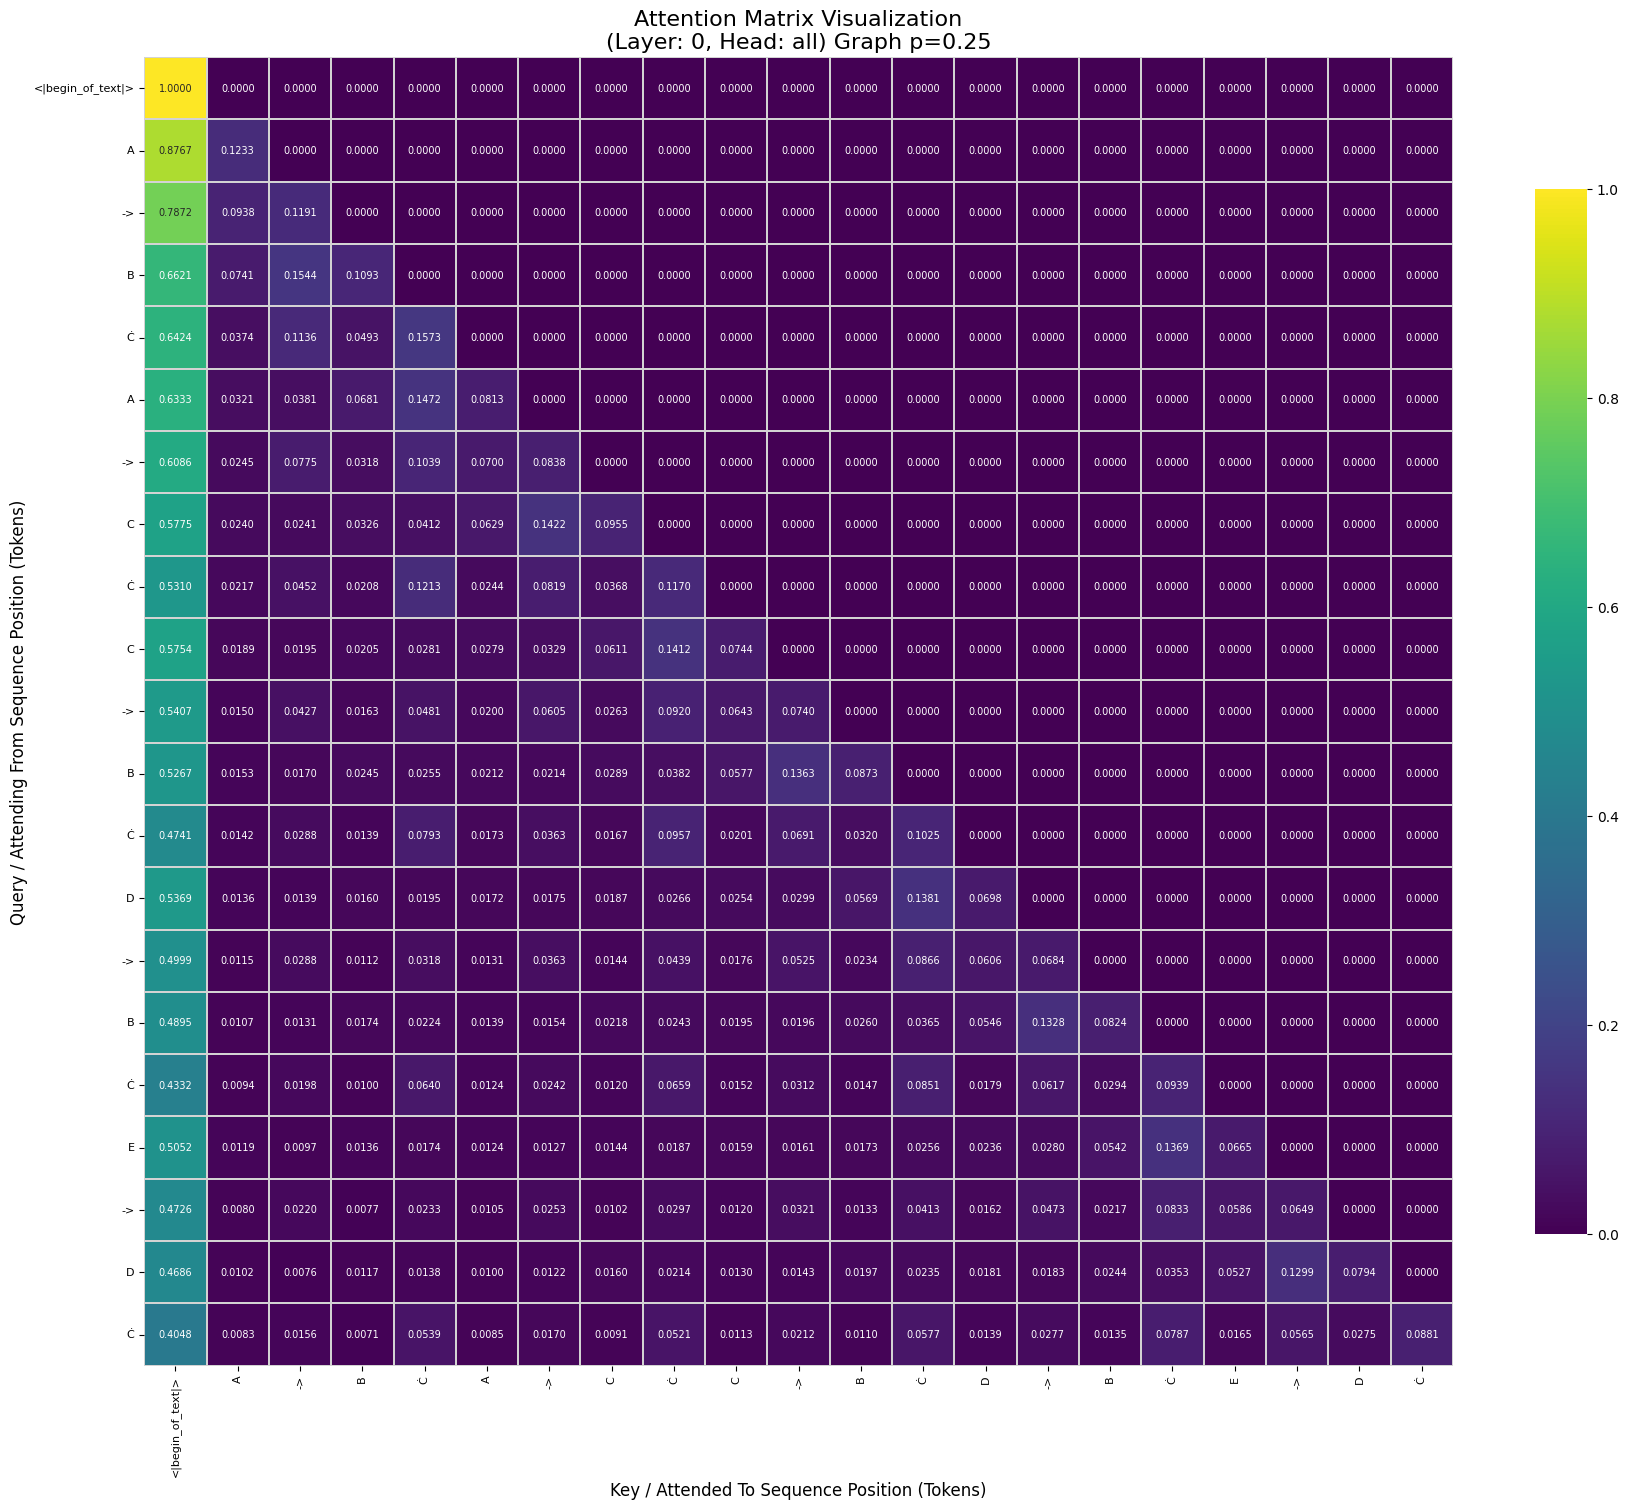

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Needed for path manipulation

# --- Configuration ---
metadata_file_path = '/Users/log/Github/Spring2025Classes/social_networks/final_project/attention_matrices/demo1/metadata.json'

# 1. Read Metadata from JSON file
try:
    with open(metadata_file_path, 'r') as f:
        # Load whatever the top-level structure is
        raw_metadata = json.load(f)

    # *** MODIFICATION START ***
    # Check if the loaded data is a list
    if isinstance(raw_metadata, list):
        if len(raw_metadata) > 0 and isinstance(raw_metadata[0], dict):
            # If it's a non-empty list and the first item is a dictionary, use that item
            metadata = raw_metadata[0]
            print("Metadata JSON was a list; extracted the first dictionary element.")
        else:
            # Handle cases like an empty list or a list not containing a dict at index 0
            raise ValueError("Metadata JSON is a list, but it's empty or the first element isn't a dictionary.")
    elif isinstance(raw_metadata, dict):
        # If it's already a dictionary, use it directly
        metadata = raw_metadata
        print("Metadata JSON was already a dictionary.")
    else:
        # If it's neither a list nor a dictionary (unlikely for valid JSON, but good to check)
        raise ValueError(f"Unexpected data type loaded from JSON: {type(raw_metadata)}. Expected dict or list containing a dict.")
    # *** MODIFICATION END ***

    print(f"Successfully processed metadata from: {metadata_file_path}")

    # Extract necessary information USING the 'metadata' dictionary
    # attention_matrix_relative_path = metadata.get("attention_matrix_path")
    # tokens = metadata.get("tokens")
    # layer = metadata.get("layer", "N/A") # Default if not found
    attention_matrix_relative_path = 'attention_matrices/demo1/avg_attn_0_0.npy' 
    tokens = ['<|begin_of_text|>', 'A', '->', 'B', 'Ċ', 'A', '->', 'C', 'Ċ', 'C', '->', 'B', 'Ċ', 'D', '->', 'B', 'Ċ', 'E', '->', 'D', 'Ċ']
    layer = metadata.get("layer", "N/A") # Default if not found
    head = metadata.get("head", "N/A")   # Default if not found

    # Basic validation
    if not attention_matrix_relative_path:
        raise ValueError("Metadata dictionary missing 'attention_matrix_path' key.")
    if not tokens:
        raise ValueError("Metadata dictionary missing 'tokens' key or it's empty.")
    if not isinstance(tokens, list):
        raise ValueError("'tokens' key in metadata dictionary must be a list.")

except FileNotFoundError:
    print(f"Error: Metadata file not found at {metadata_file_path}")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {metadata_file_path}. Check file format.")
    exit()
except ValueError as ve: # Catches ValueErrors raised in the loading/checking logic
    print(f"Error processing metadata structure: {ve}")
    exit()
except Exception as e: # Catch other potential errors during loading/parsing
    print(f"An unexpected error occurred while reading or processing metadata: {e}")
    exit()

# 2. Construct the full path to the attention matrix
# Assume the path in the JSON is relative to the JSON file's directory
json_directory = os.path.dirname(metadata_file_path)
attention_matrix_full_path = os.path.join(attention_matrix_relative_path)
# Normalize the path (optional, but good practice for consistency)
attention_matrix_full_path = os.path.normpath(attention_matrix_full_path)

print(f"Constructed full path to attention matrix: {attention_matrix_full_path}")

# 3. Load the attention matrix
try:
    attention_matrix = np.load(attention_matrix_full_path)
    print(f"Successfully loaded attention matrix from: {attention_matrix_full_path}")
except FileNotFoundError:
    print(f"\nError: Could not find the attention matrix file at the constructed path:")
    print(f"  -> {attention_matrix_full_path}")
    print(f"Please ensure the 'attention_matrix_path' ('{attention_matrix_relative_path}') in '{os.path.basename(metadata_file_path)}' is correct relative to its location.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the numpy array: {e}")
    exit()

print(f"Final attention matrix shape for plotting: {attention_matrix.shape}")

num_tokens = len(tokens)
matrix_dim1, matrix_dim2 = attention_matrix.shape

# 5. Plotting (Same as before)

plt.figure(figsize=(18, 16))
sns.heatmap(attention_matrix,
            cmap='viridis',
            square=True,
            linewidths=0.01,
            linecolor='lightgrey',
            cbar_kws={"shrink": 0.7},
            xticklabels=tokens,
            annot=True,  # This will add the cell values
            fmt=".4f",   # Format as 2 decimal places
            annot_kws={"size": 7},  # Adjust the size of the text
            yticklabels=tokens)

title = f'Attention Matrix Visualization\n(Layer: {layer}, Head: {head})'
if "connection_probability" in metadata:
     title += f' Graph p={metadata.get("connection_probability", "N/A")}' # Use .get for safety
plt.title(title, fontsize=16)
plt.xlabel('Key / Attended To Sequence Position (Tokens)', fontsize=12)
plt.ylabel('Query / Attending From Sequence Position (Tokens)', fontsize=12)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

# visualize graph

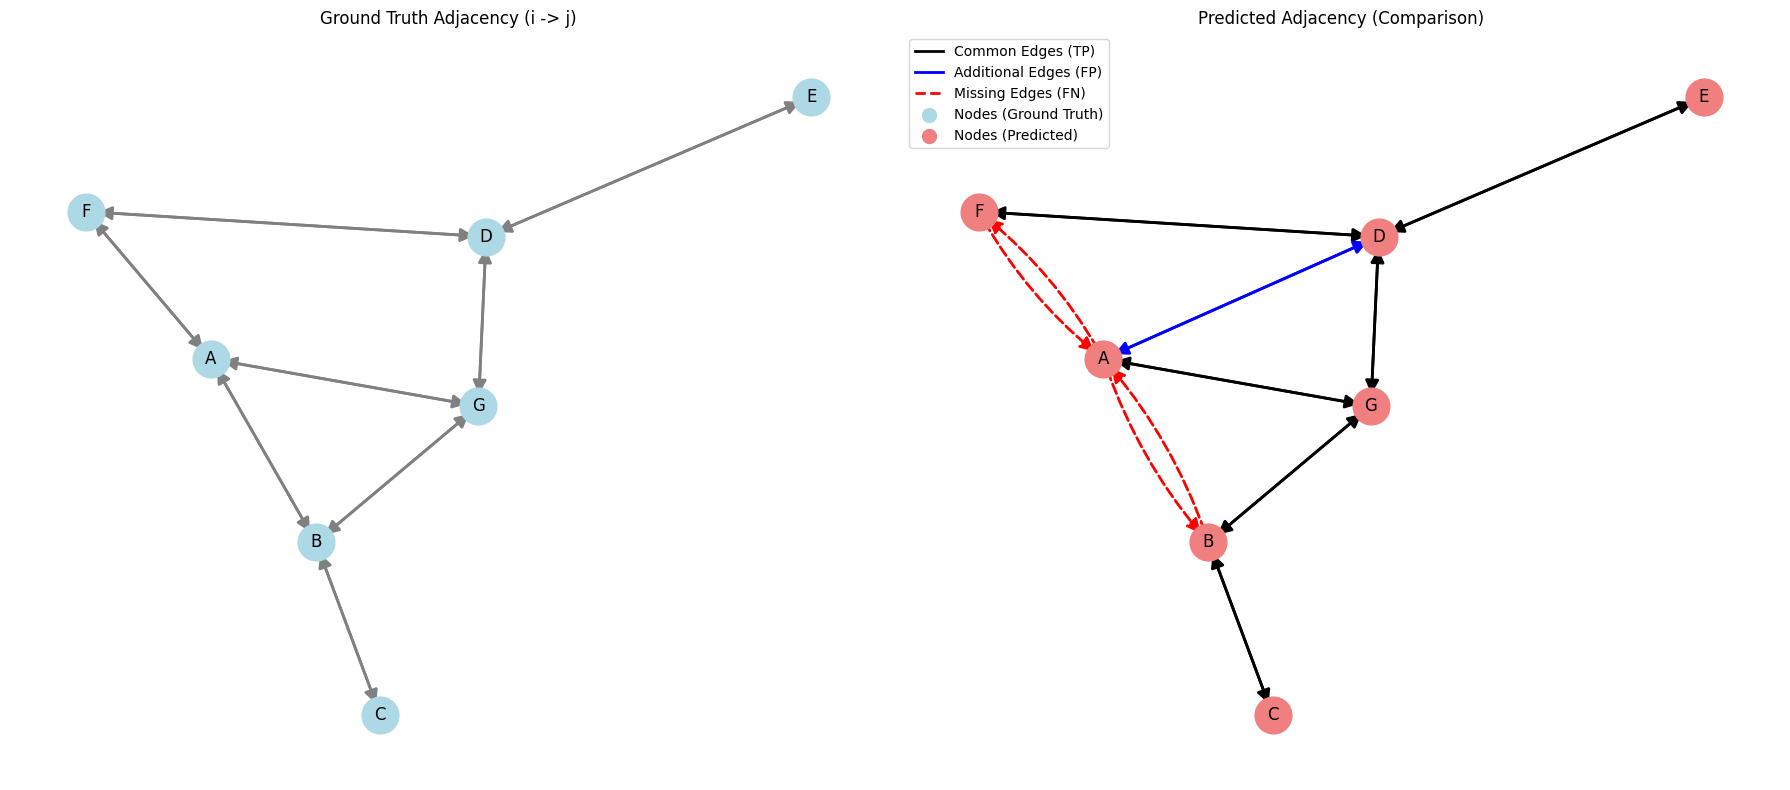

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Parse the adjacency matrices (matrix[i, j] = 1 means i -> j)
ground_truth = np.array([
    [0, 1, 0, 0, 0, 1, 1],  # A -> B, A -> F, A -> G
    [1, 0, 1, 0, 0, 0, 1],  # B -> A, B -> C, B -> G
    [0, 1, 0, 0, 0, 0, 0],  # C -> B
    [0, 0, 0, 0, 1, 1, 1],  # D -> E, D -> F, D -> G
    [0, 0, 0, 1, 0, 0, 0],  # E -> D
    [1, 0, 0, 1, 0, 0, 0],  # F -> A, F -> D
    [1, 1, 0, 1, 0, 0, 0]   # G -> A, G -> B, G -> D
])

predicted = np.array([
    [0, 0, 0, 1, 0, 0, 1],  # A -> D, A -> G
    [0, 0, 1, 0, 0, 0, 1],  # B -> C, B -> G
    [0, 1, 0, 0, 0, 0, 0],  # C -> B
    [1, 0, 0, 0, 1, 1, 1],  # D -> A, D -> E, D -> F, D -> G
    [0, 0, 0, 1, 0, 0, 0],  # E -> D
    [0, 0, 0, 1, 0, 0, 0],  # F -> D
    [1, 1, 0, 1, 0, 0, 0]   # G -> A, G -> B, G -> D
])

# # --- Alternative Test Case (Uncomment to use) ---
# ground_truth = np.array([
#     [0, 0, 1, 1, 0, 0, 0], # 0 -> 2, 0 -> 3
#     [0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 1, 0, 0, 0], # 2 -> 0, 2 -> 3
#     [1, 0, 1, 0, 0, 1, 0], # 3 -> 0, 3 -> 2, 3 -> 5
#     [0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 1, 0, 0, 0], # 5 -> 3
#     [0, 0, 0, 0, 0, 0, 0]
# ])

# predicted = np.array([
#     [0, 0, 1, 1, 0, 0, 0], # 0 -> 2, 0 -> 3
#     [0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 1, 0, 1, 0], # 2 -> 0, 2 -> 3, 2 -> 5 (Additional)
#     [1, 0, 1, 0, 0, 0, 0], # 3 -> 0, 3 -> 2 (Missing: 3->5)
#     [0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 1, 0, 0, 0, 0], # 5 -> 2 (Wrong: Should be 5->3)
#     [0, 0, 0, 0, 0, 0, 0]
# ])
# # --- End Alternative Test Case ---


# Create labels for nodes
num_nodes = ground_truth.shape[0]
node_labels = {i: chr(65+i) for i in range(num_nodes)}  # A, B, C, D, ...
edge_width = 2 # Adjusted width for potentially denser arrows
node_size = 700
font_size = 12
arrow_size = 20

# Create DIRECTED graphs from adjacency matrices
# create_using=nx.DiGraph ensures directed edges are created
G_truth = nx.from_numpy_array(ground_truth, create_using=nx.DiGraph)
G_pred = nx.from_numpy_array(predicted, create_using=nx.DiGraph)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8)) # Increased figsize slightly

# Use the same layout for both graphs
# Combine both graphs to ensure consistent node positions
# Compose works for DiGraphs too
G_combined = nx.compose(G_truth, G_pred)
pos = nx.spring_layout(G_combined, seed=42, k=0.8) # seed for reproducibility, adjusted k

# --- Draw ground truth graph (ax1) ---
nx.draw_networkx_nodes(G_truth, pos, ax=ax1, node_size=node_size, node_color='lightblue')
# For DiGraph, nx.draw_networkx_edges automatically adds arrows
nx.draw_networkx_edges(G_truth, pos, ax=ax1, width=edge_width, edge_color='gray', arrowsize=arrow_size)
nx.draw_networkx_labels(G_truth, pos, labels=node_labels, ax=ax1, font_size=font_size)
ax1.set_title('Ground Truth Adjacency (i -> j)')
ax1.axis('off') # Turn off axis lines and ticks


# --- Draw predicted graph with comparisons (ax2) ---

# Draw predicted graph nodes
nx.draw_networkx_nodes(G_pred, pos, ax=ax2, node_size=node_size, node_color='lightcoral')

# Find common edges, additional edges, and missing edges
# These are now directed edges (u, v)
common_edges = []
additional_edges = []  # Edges in predicted but not in ground truth
missing_edges = []     # Edges in ground truth but not in predicted

# Check edges predicted
for u, v in G_pred.edges():
    if G_truth.has_edge(u, v):
        common_edges.append((u, v))
    else:
        # This edge (u,v) is predicted but not in ground truth
        additional_edges.append((u, v))

# Check edges from ground truth that are missing in prediction
for u, v in G_truth.edges():
    if not G_pred.has_edge(u, v):
        # This edge (u,v) is in ground truth but not predicted
        missing_edges.append((u, v))

# Draw common edges in black (solid)
nx.draw_networkx_edges(G_pred, pos, ax=ax2, edgelist=common_edges,
                       edge_color='black', width=edge_width, arrowsize=arrow_size)

# Draw additional edges in blue (solid) - False Positives
nx.draw_networkx_edges(G_pred, pos, ax=ax2, edgelist=additional_edges,
                       edge_color='blue', width=edge_width, arrowsize=arrow_size)

# Draw missing edges in red (dashed) - False Negatives
# Note: We draw these on ax2 using the positions 'pos', even though they
# aren't technically *in* G_pred. This shows where they *should* be.
nx.draw_networkx_edges(G_truth, pos, ax=ax2, edgelist=missing_edges, # Use G_truth here to ensure correct node order if needed, though pos should dominate
                       edge_color='red', style='dashed', width=edge_width, arrowsize=arrow_size,
                       connectionstyle='arc3,rad=0.1') # Use arc to avoid overlaps if needed

# Label the nodes on the predicted graph plot
nx.draw_networkx_labels(G_pred, pos, labels=node_labels, ax=ax2, font_size=font_size)

# Set title for the second plot
ax2.set_title('Predicted Adjacency (Comparison)')
ax2.axis('off') # Turn off axis lines and ticks


# --- Add a legend to the second plot ---
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=edge_width, label='Common Edges (TP)'),
    Line2D([0], [0], color='blue', lw=edge_width, label='Additional Edges (FP)'),
    Line2D([0], [0], color='red', lw=edge_width, linestyle='dashed', label='Missing Edges (FN)')
]
# Add node color legend
legend_elements.extend([
    plt.scatter([], [], s=100, color='lightblue', label='Nodes (Ground Truth)'), # Dummy scatter for legend
    plt.scatter([], [], s=100, color='lightcoral', label='Nodes (Predicted)')      # Dummy scatter for legend
])


# Position legend nicely
ax2.legend(handles=legend_elements, loc='best') # Changed loc to 'best'

plt.tight_layout()
plt.show()

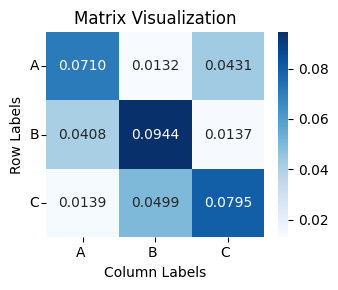

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create the sample matrix with the same values
matrix = np.array([
    [0.0710, 0.0132, 0.0431],
    [0.0408, 0.0944, 0.0137],
    [0.0139, 0.0499, 0.0795]
])

# Labels for rows and columns
labels = ['A ', 'B ', 'C ']

# Create the heatmap visualization
plt.figure(figsize=(3.5, 3))
ax = sns.heatmap(
    matrix,
    annot=True,  # Show values in the cells
    fmt=".4f",   # Format for the annotations
    cmap="Blues",  # Same color scheme as your example
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Matrix Visualization")
plt.ylabel("Row Labels")
plt.xlabel("Column Labels")
plt.xticks(rotation=0, ha="center")
plt.yticks(rotation=0, ha="center")

plt.tight_layout()
plt.savefig("matrix_visualization.png", dpi=300)
plt.show()

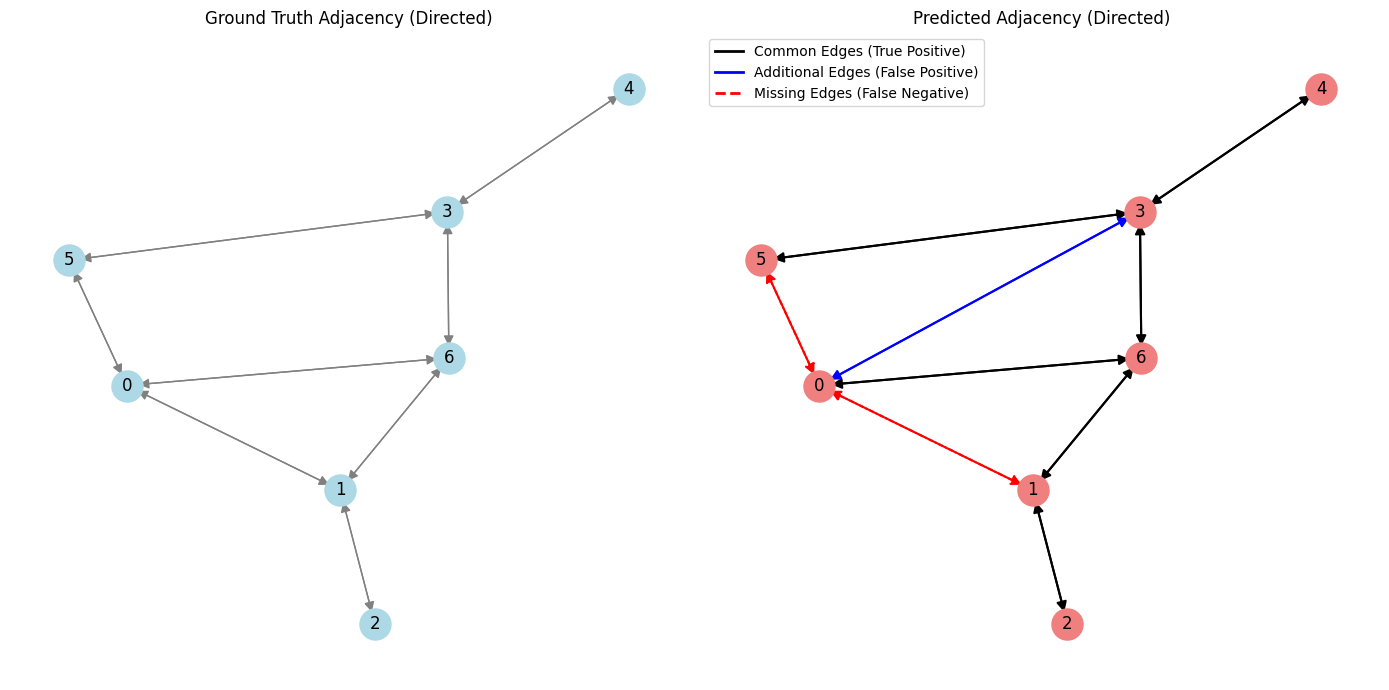

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- ASSUMPTION: You have created G_true and G_pred like this ---
# Example Adjacency Matrices (replace with your actual data)
adj_true_matrix = np.array([
    [0, 1, 1, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

adj_pred_matrix = np.array([
    [0, 1, 0, 0], # Common edge (0,1), Missing edge (0,2)
    [1, 0, 0, 1], # Additional edge (1,0), Common edge (1,3)
    [0, 1, 0, 1], # Common edge (2,1), Additional edge (2,3)
    [0, 0, 0, 0]  # Missing edge (3,0)
])

adj_true_matrix = np.array([
    [0, 1, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0]
])

adj_pred_matrix = np.array([
    [0, 0, 0, 1, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0]
])

# Create DIRECTED graphs from the adjacency matrices
G_true = nx.from_numpy_array(adj_true_matrix, create_using=nx.DiGraph)
G_pred = nx.from_numpy_array(adj_pred_matrix, create_using=nx.DiGraph)

# --- Calculate Node Positions (use a layout) ---
# Using the same layout ensures nodes align between plots
# You might want to base the layout on G_true or a union of nodes
pos = nx.spring_layout(G_true, seed=42) # Seed for reproducibility

# --- Identify Edge Sets (as tuples representing directed edges) ---
true_edges = set(G_true.edges())
pred_edges = set(G_pred.edges())

common_edges = true_edges.intersection(pred_edges)
additional_edges = pred_edges.difference(true_edges) # Edges in pred but not in true
missing_edges = true_edges.difference(pred_edges)  # Edges in true but not in pred

# --- Setup Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7)) # Increased figsize slightly

# --- Draw Ground Truth Graph (ax1) ---
nx.draw_networkx_nodes(G_true, pos, ax=ax1, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G_true, pos, ax=ax1, edge_color='gray', width=1.0,
                       arrows=True, arrowstyle='-|>', arrowsize=15) # Explicitly add arrows
nx.draw_networkx_labels(G_true, pos, ax=ax1, font_size=12)
ax1.set_title('Ground Truth Adjacency (Directed)')
ax1.axis('off') # Hide axes ticks

# --- Draw Predicted Graph Comparison (ax2) ---
node_labels = {n: str(n) for n in G_pred.nodes()} # Simple node labels
width = 1.5       # Edge width
arrow_size = 15   # Arrow size - adjust as needed

# Draw nodes
nx.draw_networkx_nodes(G_pred, pos, ax=ax2, node_size=500, node_color='lightcoral')

# Draw common edges in black
nx.draw_networkx_edges(G_pred, pos, ax=ax2, edgelist=list(common_edges), edge_color='black',
                       width=width, arrows=True, arrowstyle='-|>', arrowsize=arrow_size)

# Draw additional edges (False Positives) in blue
# Note: Original code had blue for additional, black for common. Sticking to that.
nx.draw_networkx_edges(G_pred, pos, ax=ax2, edgelist=list(additional_edges), edge_color='blue',
                       width=width, arrows=True, arrowstyle='-|>', arrowsize=arrow_size)

# Draw missing edges (False Negatives) in red with dashed lines
# IMPORTANT: These edges are *not* in G_pred. We draw them based on their coordinates (pos)
# but use G_true conceptually. Passing G_pred here works because nx uses `pos` and `edgelist`.
nx.draw_networkx_edges(G_true, pos, ax=ax2, edgelist=list(missing_edges), edge_color='red',
                       style='dashed', width=width, arrows=True, arrowstyle='-|>', arrowsize=arrow_size)
# Note: Using G_true in the call above ensures correct arrow direction if G_pred lacks nodes from G_true, though unlikely here.

# Label the nodes
nx.draw_networkx_labels(G_pred, pos, labels=node_labels, ax=ax2, font_size=12)

# Set titles
ax2.set_title('Predicted Adjacency (Directed)')
ax2.axis('off') # Hide axes ticks

# Add a legend (Adjusted labels for clarity)
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Common Edges (True Positive)'),
    Line2D([0], [0], color='blue', lw=2, label='Additional Edges (False Positive)'),
    Line2D([0], [0], color='red', lw=2, linestyle='dashed', label='Missing Edges (False Negative)')
]
# Place legend slightly better if possible
ax2.legend(handles=legend_elements, loc='best') # Changed location to 'best'

plt.tight_layout()
plt.show()